只import方便做資料處理的lib，演算法是自幹的陽春版本。

In [205]:
import pandas as pd
import numpy as np

In [206]:
# Load data
train = pd.read_table('ml-100k/u2.base', header=None, names=['uid', 'mid', 'rating', 'timestamp'])
test  = pd.read_table('ml-100k/u2.test', header=None, names=['uid', 'mid', 'rating', 'timestamp'])

n_users  = int(train.describe().loc['max', 'uid'])
n_movies = int(train.describe().loc['max', 'mid'])

 - $Y_{i, j}$放第$j$個使用者對第$i$部電影所做的評分
 - $R_{i, j}=1$代表第$j$個使用者對第$i$部電影有評分，$R_{i, j}=0$則無

In [207]:
# Transform
Y = np.zeros( (n_movies, n_users) )
R = Y.copy()
for i in range(train.shape[0]):
    Y[train.mid[i]-1][train.uid[i]-1] = train.rating[i]
    R[train.mid[i]-1][train.uid[i]-1] = 1

# Item-based Collaborative Filtering

In [208]:
# Allocate
weights    = np.empty((n_movies,n_movies))
diff       = np.empty((n_movies, n_users))
std_rating = np.empty(n_movies)

Y_mu = Y.sum(axis=1)/R.sum(axis=1)
nanindex = [l for l in range(n_movies) if np.isnan(Y_mu[l])]
for i in nanindex:
    Y_mu[nanindex] = 0
for i in range(n_movies):
    diff[i,:] = Y[i,:]-Y_mu[i]
    std_rating[i] = np.power(diff[i,:],2).sum()/(lambda _: R[i,:].sum() if R[i,:].sum()>0 else 1)(_)

In [209]:
# Weighting (Pearson correlation)
for i in range(n_movies):
    for j in range(n_movies):
        if std_rating[i]*std_rating[j]!=0:
            weights[i,j] = np.dot(R[i,:]*diff[i,:], R[j,:]*diff[j,:])/(std_rating[i]*std_rating[j])
        else:
            weights[i,j] = 0

In [220]:
rec = np.empty(200)
pred_correlation = np.empty(test.shape[0])
pred_flag        = pred_correlation.copy()
for iter in range(200):
    K   = iter+1
    tolerence = .5
    for test_id in range(test.shape[0]):
        a = test.uid[test_id]
        i = test.mid[test_id]

        sort_index = np.argsort(-weights[i,:])
        idx_positive_weights    = np.array(sort_index[:K])
        val_positive_weights    = weights[np.ix_([i],idx_positive_weights)][0]
        val_positive_difference = (diff[np.ix_(idx_positive_weights,[a])].T)[0] * (R[np.ix_(idx_positive_weights,[a])].T)[0]
        pred_correlation[test_id] = Y_mu[i] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())

        pred_flag[test_id] = 1
    pred_has_pred = [i for i in range(test.shape[0]) if pred_flag[i]]
    # Validation
    error   = test.rating.iloc[pred_has_pred] - pred_correlation[np.ix_(pred_has_pred)]
    correct = np.array([error[i] for i in range(test.shape[0]) if np.abs(error[i])<tolerence])
    rec[iter] = correct.shape[0]/float(test.shape[0])

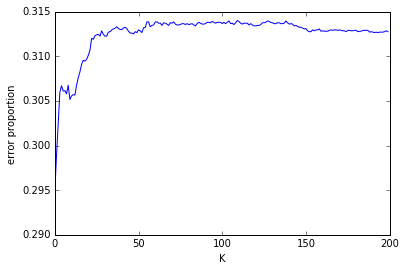

In [221]:
plot(rec)
xlabel("K")
ylabel("error proportion")

In [210]:
# Predict
pred_correlation = np.empty(test.shape[0])
pred_flag        = pred_correlation.copy()
pred_cosine      = pred_correlation.copy()
K         = 50
tolerence = .5
for test_id in range(test.shape[0]):
    a = test.uid[test_id]
    i = test.mid[test_id]

    sort_index = np.argsort(-weights[i,:])
    idx_positive_weights    = np.array(sort_index[:K])
    val_positive_weights    = weights[np.ix_([i],idx_positive_weights)][0]
    val_positive_difference = (diff[np.ix_(idx_positive_weights,[a])].T)[0] * (R[np.ix_(idx_positive_weights,[a])].T)[0]
    pred_correlation[test_id] = Y_mu[i] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())

    pred_flag[test_id] = 1
pred_has_pred = [i for i in range(test.shape[0]) if pred_flag[i]]

In [211]:
# Validation
tolerence = .5
error   = test.rating.iloc[pred_has_pred] - pred_correlation[np.ix_(pred_has_pred)]
correct = np.array([error[i] for i in range(test.shape[0]) if np.abs(error[i])<tolerence])
correct_proportion = correct.shape[0]/float(test.shape[0])

0.31265


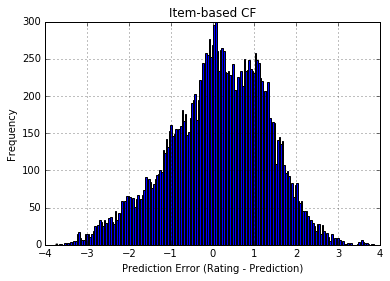

In [212]:
# Visualization
error.hist(bins=200)
plt.xlabel("Prediction Error (Rating - Prediction)")
plt.ylabel("Frequency")
plt.title("Item-based CF")
print correct_proportion

# User-based Collaborative Filtering

In [222]:
test  = pd.read_table('ml-100k/u2.test', header=None, names=['uid', 'mid', 'rating', 'timestamp'])

Y_mu = Y.sum(axis=0)/R.sum(axis=0)
nanindex = [l for l in range(n_users) if np.isnan(Y_mu[l])]
for i in nanindex:
    Y_mu[nanindex] = 0

# Allocate
weights    = np.empty((n_users,n_users))
diff       = np.empty((n_movies, n_users))
std_rating = np.empty(n_users)

for i in range(n_users):
    diff[:,i] = Y[:,i]-Y_mu[i]
    std_rating[i] = np.power(diff[:,i],2).sum()/(lambda _: R[i,:].sum() if R[i,:].sum()>0 else 1)(_)

# Weighting (Pearson correlation)
for i in range(n_users):
    for j in range(n_users):
        weights[i,j] = np.dot(R[:,i]*diff[:,i], R[:,j]*diff[:,j])/(std_rating[i]*std_rating[j])

In [223]:
rec_userbase = np.empty(200)
pred_correlation = np.empty(test.shape[0])
pred_flag        = pred_correlation.copy()
for iter in range(200):
    K   = iter+1
    tolerence = .5

    movie_avg_rating = Y.sum(axis=1)/[(lambda x: x.sum() if x.sum()>0 else 1)(R[i,:]) for i in range(n_movies)]
    for test_id in range(test.shape[0]):
        a = test.uid[test_id]
        i = test.mid[test_id]

        if i < Y.shape[1]:
            sort_index = np.argsort(-weights[:,a])
            idx_positive_weights    = np.array(sort_index[:K])
            val_positive_weights    = weights[idx_positive_weights,a]
            val_positive_difference = (diff[i,idx_positive_weights] * R[i,idx_positive_weights])
            pred_correlation[test_id] = Y_mu[i] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())
        else:
            pred_correlation[test_id] = movie_avg_rating[i]
    # Validation
    error   = test.rating - pred_correlation
    correct = np.array([error[i] for i in range(error.shape[0]) if np.abs(error[i])<tolerence])
    rec_userbase[iter] = correct.shape[0]/float(test.shape[0])



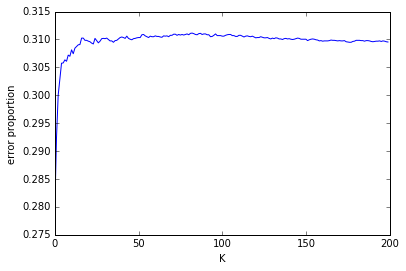

In [224]:
plot(rec_userbase)
xlabel("K")
ylabel("error proportion")

In [233]:
[sum([1 for i in range(weights.shape[0]) if weights[j,i]>0])<200 for j in range(weights.shape[0])]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [ ]:
# Predict
pred_correlation = np.zeros(test.shape[0])
pred_flag        = pred_correlation.copy()
pred_cosine      = pred_correlation.copy()
K         = 50
tolerence = .5

movie_avg_rating = Y.sum(axis=1)/[(lambda x: x.sum() if x.sum()>0 else 1)(R[i,:]) for i in range(n_movies)]
for test_id in range(test.shape[0]):
    a = test.uid[test_id]
    i = test.mid[test_id]

    if i < Y.shape[1]:
        sort_index = np.argsort(-weights[:,a])
        idx_positive_weights    = np.array(sort_index[:K])
        val_positive_weights    = weights[idx_positive_weights,a]
        val_positive_difference = (diff[i,idx_positive_weights] * R[i,idx_positive_weights])
        pred_correlation[test_id] = Y_mu[i] + np.dot(val_positive_difference,val_positive_weights)/(val_positive_weights.sum())
    else:
        pred_correlation[test_id] = movie_avg_rating[i]
# Validation
error   = test.rating - pred_correlation
correct = np.array([error[i] for i in range(error.shape[0]) if np.abs(error[i])<tolerence])
correct_proportion = correct.shape[0]/float(test.shape[0])

error.hist(bins=200)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("User-based CF")
print correct_proportion



In [183]:
test_id = argmax(pred_correlation)
a = test.uid[test_id]
i = test.mid[test_id]

In [184]:
Y.shape, i, movie_avg_rating[i]

((1682, 943), 129, 2.2999999999999998)

In [201]:
max(pred_correlation)

5.9940704628817798

In [186]:
sort_index = np.argsort(-weights[i,:])
idx_positive_weights    = np.array(sort_index[:K])
val_positive_weights    = (weights[np.ix_(idx_positive_weights,[a])].T)[0]

In [193]:
idx_positive_weights

array([404, 180, 221, 275,   0, 267, 293, 173,  55, 300,  81, 302,  12,
       654,   6, 124, 681, 129, 108, 392, 327, 199, 312, 254,  94,  91,
       346, 918, 215, 434,  20, 708, 194,  82, 879, 325,  41, 317, 290,
       143, 689, 659, 714, 322, 755, 209, 229, 662, 647, 880])

In [197]:
weights[i,idx_positive_weights]

array([  2.01860072e-03,   1.97532470e-03,   9.48681327e-04,
         7.11068733e-04,   4.79161429e-04,   3.96360631e-04,
         3.25699263e-04,   3.09522612e-04,   3.02027234e-04,
         3.00265725e-04,   2.97148770e-04,   2.76916705e-04,
         2.70465827e-04,   2.65284630e-04,   2.44399472e-04,
         2.32613403e-04,   2.32239094e-04,   2.00630749e-04,
         1.75717664e-04,   1.73279379e-04,   1.72836355e-04,
         1.68824396e-04,   1.67701708e-04,   1.67581310e-04,
         1.63231996e-04,   1.47572482e-04,   1.45299318e-04,
         1.38405458e-04,   1.29026339e-04,   1.27087561e-04,
         1.23168598e-04,   1.22288497e-04,   1.15626702e-04,
         1.10199435e-04,   1.02994183e-04,   1.01194501e-04,
         1.00934495e-04,   1.00258892e-04,   9.94430354e-05,
         9.93992986e-05,   9.93157815e-05,   9.92807629e-05,
         9.62111604e-05,   9.57912114e-05,   9.52488932e-05,
         9.40133903e-05,   9.33950525e-05,   9.13987850e-05,
         8.88947269e-05,

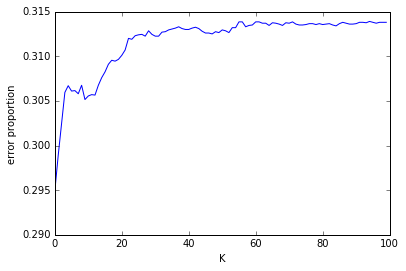

In [219]:
plot(rec)
xlabel("K")
ylabel("error proportion")